### Background
In micro and multiscale mechanics, the proper size of an RVE, along with few other factors, is highly dependent on its property of consideration. For nonlinear or complex multiphysics properties, the proper RVE size is supposed to be very large. For exact size, usually the convergence of the concerend property is tested. If the property does not change much with increasing RVE size, then that size is approximately considered as the proper size. However, determining this size is highly time-consuming and it needs a  high number of numerical simulations. Alternatively, in this notebooke a neural network based prediction of properties has been attempted in order to check the convergence of the concerend property (here is thermoelasticity) and corresponding size of the RVE.

### Dataset, input and output
The proper size of the RVE of a polycrystalline material can be treated in terms of a side length (assuming cubic volume element) or in terms of number of grains a volume element (VE) contains. A specific sized RVE can be packed with different numbers of grains, e.g. $50\times 50\times 50$ $\mu m^3$ can have approximately 80 to  120 grains considering the concerned alloy (duplex TiAl in this case). That's why the RVE size in terms of grains is not a rigorous estimate. So the unit of size here will be considered in length (i.e. $\mu m^3$). The property we are considering here is thermo-elasticity, other boundary constrains are similar to the case of [other notebook in this folder](https://github.com/helalme/DataDrivenMSE/blob/master/DD-thermoMechanical-simulation/0-ThermoElasticityPrediction.ipynb). Please see for the link for detail. However, there are two different points specific to this RVE size problem. Firstly, temperature BC will be a fixed temperature (e.g. 800C), and secondly, different sized of smaller VE have been used here for the training of NN. The training data here consists of 7 datasets of 7 different sized VEs. Here X and Y are:\
X = side lenghth of the cubic VEs e.g. 20.,38.,49..... etc.\
Y = volumetric averaged thermoelastic stresses, 20 stress values at every 10 seconds for each X


#### importing necessary modules

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

#### Loading the training dataset

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving ThermoElasticity10-1000grains.txt to ThermoElasticity10-1000grains.txt


#### Preparing X and Y for the NN model. The list from X contains the lengths of different sized VE (in $\mu m$)

In [3]:
#Reading Dataset for Thermoelasticity, Averaged sigma33 for 20 time steps 10 to 200
dataset= np.loadtxt(io.BytesIO(uploaded['ThermoElasticity10-1000grains.txt'])) 

X =  np.array([20.,38.,49.,71.,84.,95.,106.])
Y = dataset[:]
Y = np.transpose(Y)
Ytrain = Y

#### Let's visualize the property (thermoelastic stresses) for each size of VE

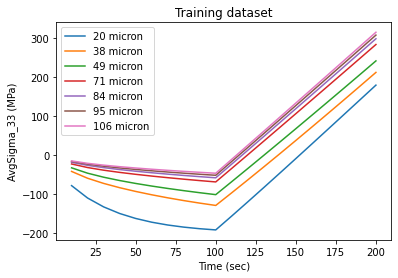

In [6]:
time=range(10,201,10)
plt.plot(time, Ytrain[0],  label='20 micron')
plt.plot(time, Ytrain[1],  label='38 micron')
plt.plot(time, Ytrain[2],  label='49 micron')
plt.plot(time, Ytrain[3],  label='71 micron')
plt.plot(time, Ytrain[4],  label='84 micron')
plt.plot(time, Ytrain[5],  label='95 micron')
plt.plot(time, Ytrain[6],  label='106 micron')

plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training dataset')
plt.legend()

plt.show()

#### Callback class for specifying the stopping criteria during the training of the NN model

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.1):
      print("\nReached MSE training<0.1, so cancelling training!")
      self.model.stop_training = True

#### Learning rate scheduler has not been attempted to find as the model here and the data set is coming nearly similar mechanics problem i.e. similar to the other [notebook](https://github.com/helalme/DataDrivenMSE/blob/master/DD-thermoMechanical-simulation/0-ThermoElasticityPrediction.ipynb). So the model and the hyperparameters are same here.

In [ ]:
callbacks = myCallback()

#Activation function use na korle model diverge kore
model = tf.keras.Sequential([
    keras.layers.Dense(units=1024, activation='relu', input_shape=[1]),
    keras.layers.Dense(units=2048,activation='relu'),
    keras.layers.Dense(units=512,activation='relu'),
    #keras.layers.Dense(units=256,activation='relu'),
    #keras.layers.Dense(units=128,activation='relu'),
    #keras.layers.Dense(units=64,activation='relu'),
    #keras.layers.Dense(units=16,activation='relu'),
    keras.layers.Dense(units=20)
])

adamOptimizer=keras.optimizers.Adam(lr=2e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(optimizer=adamOptimizer, loss='mean_squared_error')
history = model.fit(X, Ytrain, epochs=1000, callbacks=[callbacks])

Epoch 1/1000
7/7 [==============================] - 0s 46ms/sample - loss: 15061.8105
Epoch 2/1000
7/7 [==============================] - 0s 880us/sample - loss: 22951.3555
Epoch 3/1000
7/7 [==============================] - 0s 961us/sample - loss: 14226.2197
Epoch 4/1000
7/7 [==============================] - 0s 960us/sample - loss: 14337.6074
Epoch 5/1000
7/7 [==============================] - 0s 844us/sample - loss: 13526.2139
Epoch 6/1000
7/7 [==============================] - 0s 707us/sample - loss: 11678.7900
Epoch 7/1000
7/7 [==============================] - 0s 797us/sample - loss: 8340.5293
Epoch 8/1000
7/7 [==============================] - 0s 818us/sample - loss: 4711.8740
Epoch 9/1000
7/7 [==============================] - 0s 883us/sample - loss: 6169.0933
Epoch 10/1000
7/7 [==============================] - 0s 825us/sample - loss: 3860.8286
Epoch 11/1000
7/7 [==============================] - 0s 874us/sample - loss: 3742.0237
Epoch 12/1000
7/7 [============================

#### Progress of training losses 

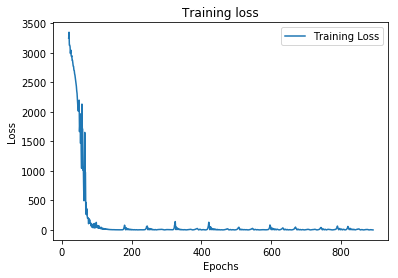

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs[20:], loss[20:],  label='Training Loss')
#plt.plot(epochs[50:], val_loss[50:],  label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend()

plt.show()

#### Here the range of X consists of 20 to 106, if we want to predict beyond this range the prediction would not suppoed to be very reliable, as it is a regression problem. Nevertheless, we will test few predictions in order to see the trend of convergence of the concerned property. Let's predict the stress behavior for X = 110, 115, and 120

In [ ]:
print(model.predict([110.0]))
print(model.predict([115.0]))
print(model.predict([120.0]))

[[-14.715613  -20.350681  -25.216179  -28.739384  -32.547115  -35.377186
  -38.274467  -41.017345  -43.4568    -45.715897   -9.6031685  26.555859
   63.50589   100.26252   136.85872   173.34402   210.43733   247.32077
  284.19336   321.5306   ]]
[[-14.335803  -19.513489  -24.46614   -27.652878  -31.682024  -34.17014
  -37.12056   -39.812786  -42.228672  -44.254955   -7.8657975  28.604507
   66.29196   103.47764   140.47623   177.29381   215.0961    252.47052
  289.73047   327.79932  ]]
[[-13.95778   -18.677923  -23.717693  -26.56871   -30.819197  -32.964928
  -35.970055  -38.611427  -41.0035    -42.796898   -6.1290946  30.653238
   69.07918   106.69442   144.09637   181.24802   219.75993   257.62668
  295.27527   334.0758   ]]


#### The above three sets show that the stress distributions are little closer, the variation of stress is within few percentage. Let's see the predictions altogether along with training sets.

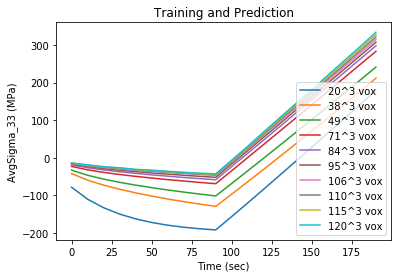

In [ ]:
time=range(0,200,10)
plt.plot(time, Ytrain[0],  label='20^3 vox')
plt.plot(time, Ytrain[1],  label='38^3 vox')
plt.plot(time, Ytrain[2],  label='49^3 vox')
plt.plot(time, Ytrain[3],  label='71^3 vox')
plt.plot(time, Ytrain[4],  label='84^3 vox')
plt.plot(time, Ytrain[5],  label='95^3 vox')
plt.plot(time, Ytrain[6],  label='106^3 vox')
plt.plot(time, model.predict([110.0])[0],  label='110^3 vox')
plt.plot(time, model.predict([115.0])[0],  label='115^3 vox')
plt.plot(time, model.predict([120.0])[0], label='120^3 vox')
plt.xlabel('Time (sec)')
plt.ylabel('AvgSigma_33 (MPa)')
plt.title('Training and Prediction')
plt.legend()

plt.show()

#### From the above figure, it is clear that the considered property (volumetric thermoelastic stresse) nearly converges at the length of 125 $\mu m^3$ approximately, accepting the error limit of 3-4%. So we can accept that the RVE size for thermoelasticity considering duplex TiAl would be approximately 125 $\mu m^3$.  Even though this result is not very precise, nevertheless, we get a rough estimate of the proper size of an RVE. A better NN can give precise estimate within negligible error bound (will be showed in another notebook).   